## Project Overview

This project demonstrates applied statistical modeling for credit risk classification using structured financial data. 
The goal is to identify key drivers of default risk, evaluate baseline model performance, and improve predictive power through feature selection and diagnostics.

A key finding is that a compact, interpretable feature set significantly outperforms
a broader baseline model under class imbalance.

Primary focus:
- Logistic regression modeling
- Model interpretability
- Performance diagnostics under class imbalance


In [1]:
import pandas as pd
df = pd.read_excel("LC_data.xlsx")

## Data and Preprocessing

The dataset contains borrower-level financial and loan characteristics. 
Preprocessing steps include variable transformation, categorical encoding, and handling missing values.


In [2]:
df['owns_home_with_mortgage'] = (df['home_ownership'] == 'MORTGAGE').astype(int)
df['owns_home_outright'] = (df['home_ownership'] == 'OWN').astype(int)

In [3]:
df['LC_grade_A'] = (df['grade'] == 'A').astype(int)
df['LC_grade_B'] = (df['grade'] == 'B').astype(int)
df['LC_grade_C'] = (df['grade'] == 'C').astype(int)
df['LC_grade_D'] = (df['grade'] == 'D').astype(int)
df['LC_grade_E'] = (df['grade'] == 'E').astype(int)

In [4]:
temp = []
for s in df['emp_length']:
    if not s in temp:
        temp.append(s)
temp

['1 year',
 '10+ years',
 nan,
 '8 years',
 '9 years',
 '5 years',
 '3 years',
 '4 years',
 '< 1 year',
 '7 years',
 '2 years',
 '6 years']

In [5]:
temp = []
for s in df['term']:
    if not s in temp:
        temp.append(s)
temp

[' 60 months', ' 36 months', nan]

In [6]:
def convert_emp_length(x):
    if pd.isnull(x):
        return None
    if "<" in x:
        return 0
    elif "+" in x:
        return 10
    else:
        return int(x.split()[0])

df['years_employed'] = df['emp_length'].apply(convert_emp_length)

In [7]:
def month2number(x):
    if pd.isnull(x):
        return None
    elif "36" in x:
        return 36
    elif "60" in x:
        return 60
        
df['loan_term_months'] = df['term'].apply(month2number)
df

,Unnamed: 0,id,member_id,loan_amnt,term,int_rate,installment,grade,emp_title,emp_length,...,default,owns_home_with_mortgage,owns_home_outright,LC_grade_A,LC_grade_B,LC_grade_C,LC_grade_D,LC_grade_E,years_employed,loan_term_months
0,0,263591,545710,20000.0,60 months,17.93,342.94,E,Wylie ISD,1 year,...,1,1,0,0,0,0,0,1,1.0,60.0
1,1,1613916,69664096,30000.0,36 months,11.99,996.29,C,Sergeant,10+ years,...,0,1,0,0,0,1,0,0,10.0,36.0
2,2,818934,8965180,21500.0,36 months,11.99,714.01,B,Designer,1 year,...,0,0,0,0,1,0,0,0,1.0,36.0
3,3,1606612,70572960,10000.0,36 months,13.67,340.18,C,NaN,NaN,...,0,0,0,0,0,1,0,0,NaN,36.0
4,4,1639932,68589517,5000.0,36 months,8.49,157.82,B,Sr. Manufacturing Engineer,10+ years,...,0,1,0,0,1,0,0,0,10.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24995,901888,4974773,10500.0,36 months,10.16,339.60,B,Schneider Electric,5 years,...,0,1,0,0,1,0,0,0,5.0,36.0
24996,24996,945413,1279809,12000.0,36 months,14.33,412.06,C,Clark County School District,10+ years,...,0,0,0,0,0,1,0,0,10.0,36.0
24997,24997,366944,63496281,25000.0,36 months,12.69,838.63,C,sales consultant,< 1 year,...,0,1,0,0,0,1,0,0,0.0,36.0
24998,24998,1043529,98124387,12200.0,60 months,13.49,280.66,C,NaN,NaN,...,0,0,1,0,0,1,0,0,NaN,60.0


In [8]:
features_all = [
    "loan_amnt",
    "loan_term_months",
    "int_rate",
    "installment",
    "LC_grade_A",
    "LC_grade_B",
    "LC_grade_C",
    "LC_grade_D",
    "years_employed",
    "owns_home_with_mortgage",
    "owns_home_outright",
    "delinq_2yrs",
    "open_acc",
    "revol_bal",
    "revol_util",
    "total_acc",
    "tot_cur_bal",
    "annual_inc",
    "dti",
    "fico_range_high",
    "last_fico_range_high"
]

features_all_with_y = features_all + ["default"]
df_useful = df[features_all_with_y]
df_useful

,loan_amnt,loan_term_months,int_rate,installment,LC_grade_A,LC_grade_B,LC_grade_C,LC_grade_D,years_employed,owns_home_with_mortgage,...,open_acc,revol_bal,revol_util,total_acc,tot_cur_bal,annual_inc,dti,fico_range_high,last_fico_range_high,default
0,20000.0,60.0,17.93,342.94,0,0,0,0,1.0,1,...,6.0,5673.0,97.8,20.0,NaN,44304.0,18.47,694.0,594.0,1
1,30000.0,36.0,11.99,996.29,0,0,1,0,10.0,1,...,12.0,13383.0,40.7,34.0,69594.0,136000.0,20.63,674.0,739.0,0
2,21500.0,36.0,11.99,714.01,0,1,0,0,1.0,0,...,13.0,14071.0,36.2,44.0,74939.0,50000.0,29.62,739.0,704.0,0
3,10000.0,36.0,13.67,340.18,0,0,1,0,NaN,0,...,9.0,8057.0,57.5,20.0,16824.0,64400.0,16.68,679.0,669.0,0
4,5000.0,36.0,8.49,157.82,0,1,0,0,10.0,1,...,4.0,3055.0,92.6,5.0,77053.0,88000.0,5.32,664.0,699.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,10500.0,36.0,10.16,339.60,0,1,0,0,5.0,1,...,11.0,10180.0,59.5,30.0,243142.0,78000.0,9.58,689.0,744.0,0
24996,12000.0,36.0,14.33,412.06,0,0,1,0,10.0,0,...,13.0,7711.0,58.0,23.0,64497.0,82000.0,11.75,694.0,549.0,0
24997,25000.0,36.0,12.69,838.63,0,0,1,0,0.0,1,...,12.0,22014.0,74.1,51.0,150935.0,60000.0,13.34,669.0,609.0,0
24998,12200.0,60.0,13.49,280.66,0,0,1,0,NaN,0,...,5.0,12805.0,59.6,15.0,13615.0,44400.0,10.59,699.0,699.0,0


## Missing Value Handling

Several financial variables contain missing values. 
To avoid information loss and bias, multiple imputation via MICE is applied to estimate missing entries based on observed relationships among variables.


In [9]:
from statsmodels.imputation.mice import MICEData

mice_data = MICEData(df_useful)

for i in range(10):
    mice_data.update_all()
    
df_imputed = mice_data.data

In [10]:
features_A_with_y = ["annual_inc", "dti", "loan_amnt", "fico_range_high", "delinq_2yrs" , "default"]
df_A = df_imputed[features_A_with_y]

## Train-Test Split

The dataset is split into training and testing sets to evaluate out-of-sample performance.

## Baseline Logistic Regression

A baseline logistic regression model is estimated to assess initial predictive performance.


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


Confusion Matrix:
 [[4486    0]
 [ 514    0]]

Accuracy: 0.8972
Sensitivity (Recall): 0.0000
Specificity: 1.0000
AUC Score: 0.6138


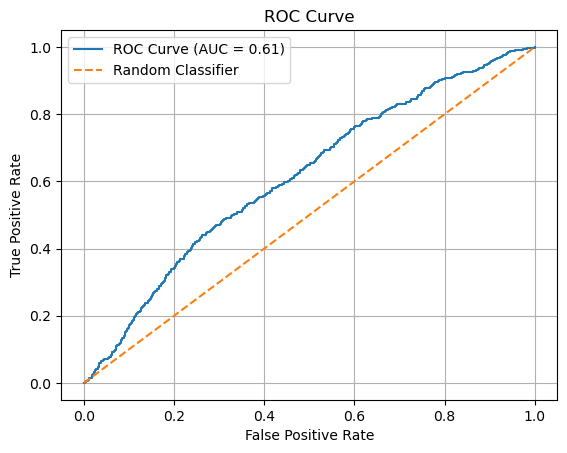


Odds Ratios:
            Feature  Coefficient  Odds Ratio
0       annual_inc    -0.000006    0.999994
1              dti     0.002663    1.002667
2        loan_amnt     0.000026    1.000026
3  fico_range_high    -0.013358    0.986731
4      delinq_2yrs    -0.039974    0.960814


In [12]:
features_A = ["annual_inc", "dti", "loan_amnt", "fico_range_high", "delinq_2yrs"]
X = df_imputed[features_A]
y = df_imputed["default"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()
print("Confusion Matrix:\n", cm)

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(f"AUC Score: {auc:.4f}")

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

odds_ratios = pd.DataFrame({
    "Feature": features_A,
    "Coefficient": model.coef_[0],
    "Odds Ratio": np.exp(model.coef_[0])
})
print("\nOdds Ratios:\n", odds_ratios)

## Model Interpretation and Diagnostics

- **Income Effect**:  
  The estimated odds ratio for annual income is slightly below 1, indicating that higher income is associated with lower default risk. For example, a $10,000 increase in income corresponds to approximately a 6% decrease in default odds, holding other factors constant.

- **Loan Size Effect**:  
  The odds ratio for loan amount is slightly above 1, implying that larger loan sizes are associated with higher default risk. A $10,000 increase in loan amount corresponds to roughly a 30% increase in default odds.

- **Model Discrimination**:  
  The baseline logistic regression achieves an AUC of approximately 0.61, only marginally better than random. Examination of the confusion matrix reveals that the model predicts predominantly one class, suggesting class imbalance and threshold issues, limiting practical usefulness.


## Feature-Focused Experiment

Motivated by the baseline failure, I conducted targeted experiments using a reduced feature set.
In particular, a model built primarily on `last_fico_range_high` demonstrates:

- AUC ≈ 0.95
- Substantially improved recall
- Clear separation between default and non-default cases


Confusion Matrix:
 [[4367  119]
 [ 200  314]]

Accuracy: 0.9362
Sensitivity (Recall): 0.6109
Specificity: 0.9735
AUC Score: 0.9497


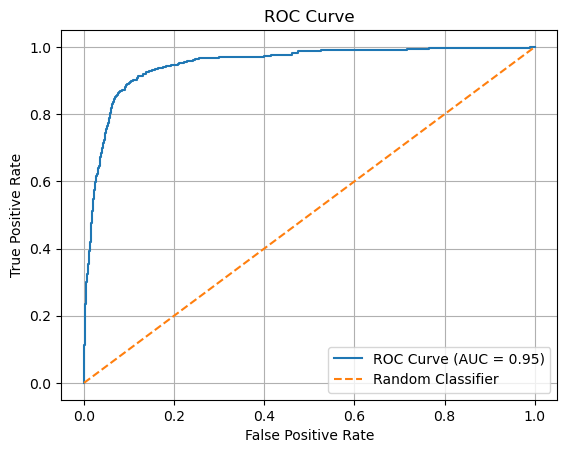


Odds Ratios:
                 Feature  Coefficient  Odds Ratio
0            annual_inc    -0.000004    0.999996
1                   dti     0.003677    1.003684
2             loan_amnt     0.000051    1.000051
3  last_fico_range_high    -0.032188    0.968325
4           delinq_2yrs    -0.088024    0.915739


In [13]:
features_A = ["annual_inc", "dti", "loan_amnt", "last_fico_range_high", "delinq_2yrs"]

X = df_imputed[features_A]
y = df_imputed["default"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()
print("Confusion Matrix:\n", cm)

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(f"AUC Score: {auc:.4f}")

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

odds_ratios = pd.DataFrame({
    "Feature": features_A,
    "Coefficient": model.coef_[0],
    "Odds Ratio": np.exp(model.coef_[0])
})
print("\nOdds Ratios:\n", odds_ratios)

In [14]:
import statsmodels.api as sm

features_b = [
    "loan_amnt",
    "loan_term_months",
    "int_rate",
    "installment",
    "LC_grade_A",
    "LC_grade_B",
    "LC_grade_C",
    "LC_grade_D",
    "years_employed",
    "owns_home_with_mortgage",
    "owns_home_outright",
    "delinq_2yrs",
    "open_acc",
    "revol_bal",
    "revol_util",
    "total_acc",
    "tot_cur_bal",
    "annual_inc",
    "dti",
    "last_fico_range_high"
]

features_b_with_y = features_b + ["default"]

def get_new_AIC_scores(old_features, remaining_features, X, y):
    aic_records = []
    for f in remaining_features:
        new_features = old_features + [f] 
        #print(new_features)
        X_new = sm.add_constant(X[new_features])
        model = sm.Logit(y, X_new).fit(disp=0)
        y_pred_prob = model.predict(X_new) 
        auc = roc_auc_score(y, y_pred_prob) 
        aic = model.aic

        aic_records.append({
            "added_feature": f,
            "new_features": new_features,
            "aic": auc,
            "remaining_features_after_add": [feat for feat in remaining_features if feat != f]
        })
    best_record = max(aic_records, key=lambda x: x['aic']) 
    return best_record

old_features = []
remaining_features = features_b

exit = False
current_aic = 0
df_B = df_imputed[features_b_with_y]
X = df_B[features_b]
y = df_B["default"]
count = 0
while exit == False:
    print(count)
    print(current_aic)
    #print(old_features)
    #print(remaining_features)
    new_score = get_new_AIC_scores(old_features=old_features, remaining_features=remaining_features, X=X, y=y)
    #print(new_score["aic"])
    if new_score["aic"] > current_aic:
        old_features = new_score["new_features"]
        current_aic = new_score["aic"]
        remaining_features = new_score["remaining_features_after_add"]
        count+=1
        print(new_score["added_feature"])
    else:
        exit = True

final_features = old_features
final_features

0
0
last_fico_range_high
1
0.9443449760729615
loan_amnt
2
0.9457290237602055
total_acc
3
0.9465010573607835
annual_inc
4
0.9473246359599623
delinq_2yrs
5
0.9476530741390116
loan_term_months
6
0.9479057457007803
open_acc
7
0.9480323777172887
tot_cur_bal
8
0.9481264063895166
owns_home_with_mortgage
9
0.9482361355498242
dti
10
0.948325267621441
revol_util
11
0.9483979499031057
revol_bal
12
0.9484712246560186
installment
13
0.9485493263070425
LC_grade_A
14
0.9485859723963115
LC_grade_D
15
0.9486142541856045
LC_grade_B
16
0.9486499418655013
LC_grade_C
17
0.9487255342265326
int_rate
18
0.948868720586743


['last_fico_range_high',
 'loan_amnt',
 'total_acc',
 'annual_inc',
 'delinq_2yrs',
 'loan_term_months',
 'open_acc',
 'tot_cur_bal',
 'owns_home_with_mortgage',
 'dti',
 'revol_util',
 'revol_bal',
 'installment',
 'LC_grade_A',
 'LC_grade_D',
 'LC_grade_B',
 'LC_grade_C',
 'int_rate']

## Key Takeaways

- More features do not guarantee better performance in imbalanced classification problems
- Feature interpretability is critical for credit risk modeling
- Simple, well-chosen signals can outperform complex multivariate models
